# (optional) How to solve OOV problem

#### Q1: How did you solve this problem in your programming task?

1. 实现设定一个固定的字典，在训练LM过程中，所有不在字典中的单词统一转换成 token <UNK>，
2. 另一种是将LM中出现频率小于n次的单词当作 <UNK>，剩下的作为字典。 
    根据字典对测试数据做相同操作，就可以避免OOV的问题。

#### Q2: Read about the 'Turing-Good Estimator', can explain the main points about this method, and may implement this method in your programming task

# 3. Using Wikipedia dataset to finish the language model.

Step 1: You need to download the corpus from wikipedis:

https://dumps.wikimedia.org/zhwiki/20190401/

Step 2: You may need the help of wiki-extractor:

https://github.com/attardi/wikiextractor

Step 3: Using the technologies and methods to finish the language model;

Step 4: Try some interested sentence pairs, and check if your model could fit them

Step 5: If we need to solve following problems, how can language model help us?

Voice Recognization.
Sogou pinyin input.
Auto correction in search engine.
Abnormal Detection.

### step
1. 下载
2. 使用wiki-extractor处理成纯文本，以100M分割，共得到13个文件
3. 使用opencc将繁体转化为简体--代码中直接用的简体版本，这里仅使用三个文件来做

In [1]:
import os 
import pandas as pd
import re
import jieba
import logging
from icecream import ic
from collections import Counter
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
database = 'F:\lesson02\wiki_tansfer\wiki10'

In [3]:
os.path.exists(database)

True

In [4]:
## 读取文件的时候找不到好的方法一直报错，这里借鉴徐馨薇同学的读文件

import glob
import errno

all_articles = []

file_path = 'F:\lesson02\wiki_tansfer\wiki**'

files = glob.glob(file_path)

for file in files:
    try:
        text_file = open(file, 'r', encoding='utf8')
        lines = text_file.readlines()
        all_articles.append(lines)
    except IOError as exc:
        if exc.errno != errno.EISDIR:
            raise


In [5]:
all_articles[0]
       

['<doc id="210325" url="https://zh.wikipedia.org/wiki?curid=210325" title="X射线管">\n',
 'X射线管\n',
 '\n',
 'X射线管是能够发生X射线的一个设备或设备的部件。\n',
 '\n',
 'X射线管都包含阴极和阳极组件，其皆位于真空的材料密封罩内亦即为真空管。\n',
 '其是由钨丝绕成线圈的形式装在一个浅的聚焦杯（focusing cup）中，当钨丝通过足够的电流时，使其产生白热现象时电子会从钨的表面逸出形成电子云。\n',
 '主要为钨靶，通常是由钨或钨铼合金所制成，其作用在于使阴极来的高速电子停止运动。\n',
 '\n',
 '1. 根据密封材质不同，可分为玻璃管、陶瓷管和金属陶瓷管。\n',
 '2. 根据用途不同，可分为医疗X射线管和工业X射线管。\n',
 '3. 根据密封方式不同，可分为开放式X射线管：在使用过程中需要不断抽真空。密闭式X射线管：生产X射线管时抽真空到一定程度后立即密封，使用过程中无需再次抽真空。\n',
 '\n',
 'X线是由高速运行的电子群撞击物质突然被阻时产生的。因此，它的产生，必须具备以下3个条件：\n',
 '\n',
 '\n',
 '当钨丝通过足够的电流使其产生电子云，且有足够的电压（千伏等级）加在阳极和阴极间，使得电子云被拉往阳极。此时电子以高能高速的状态撞击钨靶，其部分能量约1%将转换成X射线，剩下的能量转换成热能。\n',
 '\n',
 '\n',
 'x射线可使以下物质发出荧光：钨酸钙CaWO4、氟化钙CaF、硫化锌ZnS、铂氰化钾K2Pt(CN)6、铂氰化钙CaPt(CN)6、铂氰化钡BaPt(CN)6\n',
 '\n',
 '\n',
 '\n',
 '</doc>\n',
 '<doc id="210329" url="https://zh.wikipedia.org/wiki?curid=210329" title="淀粉酶">\n',
 '淀粉酶\n',
 '\n',
 '淀粉酶（拼音：diàn-fěn méi；注音：ㄉㄧㄢˋ ㄈㄣˇ ㄇㄟˊ；法语, 德语, 英文：Amylase）是一种水解酶，是目前发酵工业上应用最广泛的一类酶。淀粉酶一般作用于可溶性淀粉、直链淀粉、糖原等α-1,4-葡聚糖，水解α

In [12]:
## 去除<doc>标签以及换行符
## 跑的太久了，等了半个小时也没跑出来 我就取前面1000个字符串

TEXT = ''

for element in all_articles[0][:1000]:
    if element.startswith('<doc id') or element.startswith('</doc>'): 
        all_articles[0][:1000].remove(element)
    else:
        TEXT += element


In [14]:
TEXT = TEXT.strip('\n')
print(TEXT)

X射线管

X射线管是能够发生X射线的一个设备或设备的部件。

X射线管都包含阴极和阳极组件，其皆位于真空的材料密封罩内亦即为真空管。
其是由钨丝绕成线圈的形式装在一个浅的聚焦杯（focusing cup）中，当钨丝通过足够的电流时，使其产生白热现象时电子会从钨的表面逸出形成电子云。
主要为钨靶，通常是由钨或钨铼合金所制成，其作用在于使阴极来的高速电子停止运动。

1. 根据密封材质不同，可分为玻璃管、陶瓷管和金属陶瓷管。
2. 根据用途不同，可分为医疗X射线管和工业X射线管。
3. 根据密封方式不同，可分为开放式X射线管：在使用过程中需要不断抽真空。密闭式X射线管：生产X射线管时抽真空到一定程度后立即密封，使用过程中无需再次抽真空。

X线是由高速运行的电子群撞击物质突然被阻时产生的。因此，它的产生，必须具备以下3个条件：


当钨丝通过足够的电流使其产生电子云，且有足够的电压（千伏等级）加在阳极和阴极间，使得电子云被拉往阳极。此时电子以高能高速的状态撞击钨靶，其部分能量约1%将转换成X射线，剩下的能量转换成热能。


x射线可使以下物质发出荧光：钨酸钙CaWO4、氟化钙CaF、硫化锌ZnS、铂氰化钾K2Pt(CN)6、铂氰化钙CaPt(CN)6、铂氰化钡BaPt(CN)6



淀粉酶

淀粉酶（拼音：diàn-fěn méi；注音：ㄉㄧㄢˋ ㄈㄣˇ ㄇㄟˊ；法语, 德语, 英文：Amylase）是一种水解酶，是目前发酵工业上应用最广泛的一类酶。淀粉酶一般作用于可溶性淀粉、直链淀粉、糖原等α-1,4-葡聚糖，水解α-1,4-糖苷键的酶。根据作用的方式可分为α-淀粉酶（EC3.2.1.1.）与β-淀粉酶（EC3.2.1.2.）。

α-淀粉酶广泛分布于动物（唾液、胰脏等）、植物（麦芽、山萮菜）及微生物。微生物的酶几乎都是分泌性的。此酶以Ca为必需因子并作为稳定因子，既作用于直链淀粉，亦作用于支链淀粉，无差别地切断α-1,4-链。因此，其特征是引起底物溶液粘度的急剧下降和碘反应的消失，最终产物在分解直链淀粉时以麦芽糖为主，此外，还有麦芽三糖及少量葡萄糖。另一方面在分解支链淀粉时，除麦芽糖、葡萄糖外，还生成分支部分具有α-1,6-键的α-极限糊精。一般分解限度以葡萄糖为准是35-50％，但在细菌的淀粉酶中，亦有呈现高达70％分解限度的（最终游离出葡萄糖）。

β-淀粉

In [15]:
## 去掉特殊字符
def token(string):
    return ''.join(re.findall('[\w|\d]+', string))

In [16]:
TEXT_TOKEN = token(TEXT)
TEXT_TOKEN[:100]

'X射线管X射线管是能够发生X射线的一个设备或设备的部件X射线管都包含阴极和阳极组件其皆位于真空的材料密封罩内亦即为真空管其是由钨丝绕成线圈的形式装在一个浅的聚焦杯focusingcup中当钨丝通过足够'

In [17]:
###  分词
def cut(string): return list(jieba.cut(string))

In [18]:
SOME_TOKEN = cut(TEXT_TOKEN)
SOME_TOKEN[:10]

Building prefix dict from the default dictionary ...
Loading model from cache C:\Users\XIONGF~1\AppData\Local\Temp\jieba.cache
Loading model cost 0.859 seconds.
Prefix dict has been built succesfully.


['X射线', '管', 'X射线', '管是', '能够', '发生', 'X射线', '的', '一个', '设备']

In [19]:
valid_tokens = [t for t in SOME_TOKEN if t.strip()]

In [20]:
len(SOME_TOKEN)


15914

In [21]:
len(valid_tokens)

15914

### 获得词频 and 1-gram

In [22]:
words_count = Counter(valid_tokens)

In [24]:
words_count.most_common(10)

[('的', 908),
 ('在', 224),
 ('是', 189),
 ('年', 162),
 ('为', 140),
 ('了', 126),
 ('有', 99),
 ('调景岭', 98),
 ('和', 86),
 ('与', 85)]

In [25]:
## 获得频率最高的100个词的词频
frequences = [f for w,f in words_count.most_common(100)]

In [29]:
x = [x for x in range(len(frequences[:100]))]
len(frequences)

100

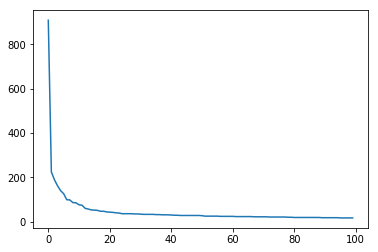

In [30]:
plt.plot(x, frequences)

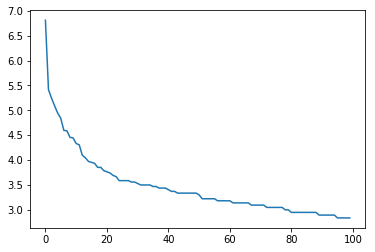

In [33]:
import numpy as np
plt.plot(x,np.log(frequences))

In [34]:
frequences_all = [f for w, f in words_count.most_common()]
frequences_sum = sum(frequences_all)
print(frequences_sum)
print(1/frequences_sum)

15914
6.283775292195552e-05


In [38]:
## 获取词的频率
def get_prob(word): 
    esp = 1 / frequences_sum
    if word in words_count: 
        return words_count[word] / frequences_sum
    else:
        return esp

from functools import reduce
## 获取累计乘---这里主要用来计算一个句子的频率
def product(numbers):
    return reduce(lambda n1, n2: n1 * n2, numbers)


##  以1-gram为基础，得到该string的概率
def language_model_one_gram(string):
    words = cut(string)
    return product([get_prob(w) for w in words])

In [39]:
get_prob('我们')

6.283775292195552e-05

In [40]:
language_model_one_gram('长征火箭下周发射')

1.5591309226361872e-17

In [41]:
sentences = """
这是一个比较正常的句子
这个一个比较罕见的句子
小明毕业于清华大学
小明毕业于秦华大学
""".split()


for s in sentences:
    print(s, language_model_one_gram(s))

这是一个比较正常的句子 1.4086732477515378e-20
这个一个比较罕见的句子 9.860712734260763e-20
小明毕业于清华大学 8.107480797708172e-16
小明毕业于秦华大学 5.094558751858849e-20


In [42]:
need_compared = [
    "今天晚上请你吃大餐，我们一起吃日料 明天晚上请你吃大餐，我们一起吃苹果",
    "真事一只好看的小猫 真是一只好看的小猫",
    "我去吃火锅，今晚 今晚我去吃火锅"
]

for s in need_compared:
    s1, s2 = s.split()
    p1, p2 = language_model_one_gram(s1), language_model_one_gram(s2)
    
    better = s1 if p1 > p2 else s2
    
    print('{} is more possible'.format(better))
    print('-'*4 + ' {} with probility {}'.format(s1, p1))
    print('-'*4 + ' {} with probility {}'.format(s2, p2))
    

明天晚上请你吃大餐，我们一起吃苹果 is more possible
---- 今天晚上请你吃大餐，我们一起吃日料 with probility 1.2063049354472975e-46
---- 明天晚上请你吃大餐，我们一起吃苹果 with probility 9.65043948357838e-46
真是一只好看的小猫 is more possible
---- 真事一只好看的小猫 with probility 1.117994641072649e-22
---- 真是一只好看的小猫 with probility 8.89588335901507e-19
今晚我去吃火锅 is more possible
---- 我去吃火锅，今晚 with probility 4.898614184479663e-21
---- 今晚我去吃火锅 with probility 7.795654613180935e-17


## 2-gram

In [43]:
va_tokens = [str(t) for t in valid_tokens]

all_2_grams_words = [''.join(va_tokens[i:i+2]) for i in range(len(va_tokens[:-2]))]

_2_gram_sum = len(all_2_grams_words)
_2_gram_counter = Counter(all_2_grams_words)


In [46]:
##获取两个字在一起出现的频率
def get_combination_prob(w1, w2):
    if w1 + w2 in _2_gram_counter: return _2_gram_counter[w1+w2] / _2_gram_sum
    else:
        return 1 / _2_gram_sum

    
## 条件概率那个公式 
def get_prob_2_gram(w1, w2):
    return get_combination_prob(w1, w2) / get_prob(w1)
    
##2-gram  句子在里2-gram下出现的频率
def langauge_model_of_2_gram(sentence):
    sentence_probability = 1
    
    words = cut(sentence)
    
    for i, word in enumerate(words):
        if i == 0: 
            prob = get_prob(word)
        else:
            previous = words[i-1]
            prob = get_prob_2_gram(previous, word)
        sentence_probability *= prob
    
    return sentence_probability

In [47]:
langauge_model_of_2_gram('小明今天抽奖抽到一台苹果手机')

7.860644596167209e-06